In [102]:
import numpy as np
import torch
import os
from sklearn import svm
import pywt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from sklearn.manifold import TSNE
import torch.nn as nn
from torch.nn.functional import softmax, relu
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score

path_figures = './figures'
if not os.path.exists(path_figures):
    os.makedirs(path_figures)

path_model = './models'
if not os.path.exists(path_model):
    os.makedirs(path_model)

load dataset and check data shape

In [94]:
data_path = './data'
X_train_valid = np.load(os.path.join(data_path, 'X_train_valid.npy'))
y_train_valid = np.load(os.path.join(data_path, 'y_train_valid.npy'))
X_test = np.load(os.path.join(data_path, 'X_test.npy'))
y_test = np.load(os.path.join(data_path, 'y_test.npy'))
person_train_valid = np.load(os.path.join(data_path, 'person_train_valid.npy'))
person_test = np.load(os.path.join(data_path, 'person_test.npy'))

print(X_train_valid.shape)
print(y_train_valid.shape)
print(X_test.shape)
print(y_test.shape)
print(person_train_valid.shape)
print(person_test.shape)

def func_categorical_label(y):
    y[y == 769] = 0
    y[y == 770] = 1
    y[y == 771] = 2
    y[y == 772] = 3
    return y

# minmax normalization
def func_normalize(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))

X_train_valid = func_normalize(X_train_valid)
X_test = func_normalize(X_test)

# change the label from subject index (769, ...) to (0, 1, 2, 3)
y_train_valid = func_categorical_label(y_train_valid)
y_test = func_categorical_label(y_test)

(2115, 22, 1000)
(2115,)
(443, 22, 1000)
(443,)
(2115, 1)
(443, 1)


Compute wavelet transform embedding with various levels

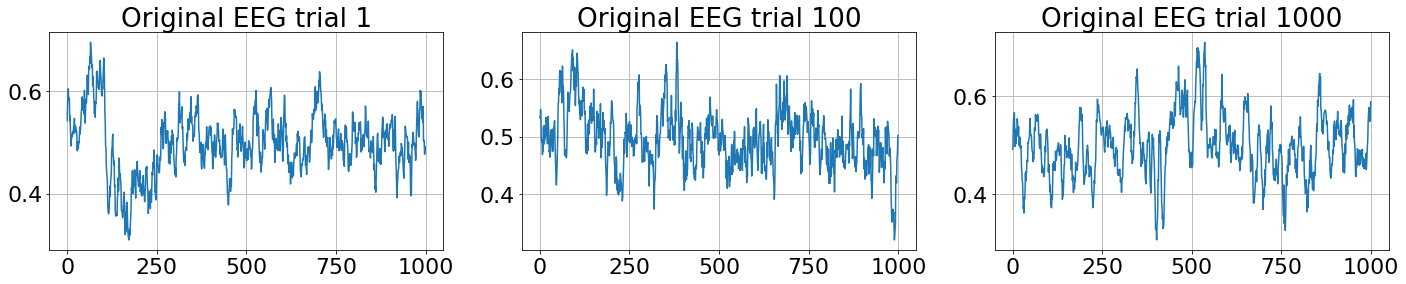

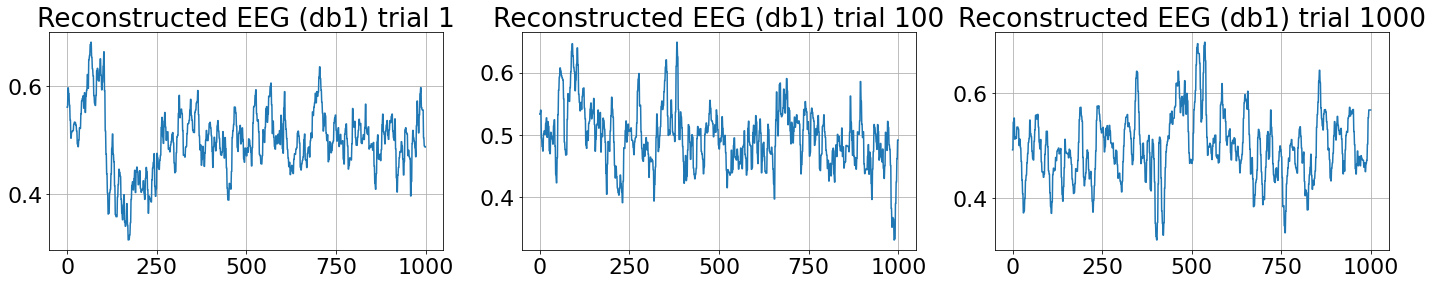

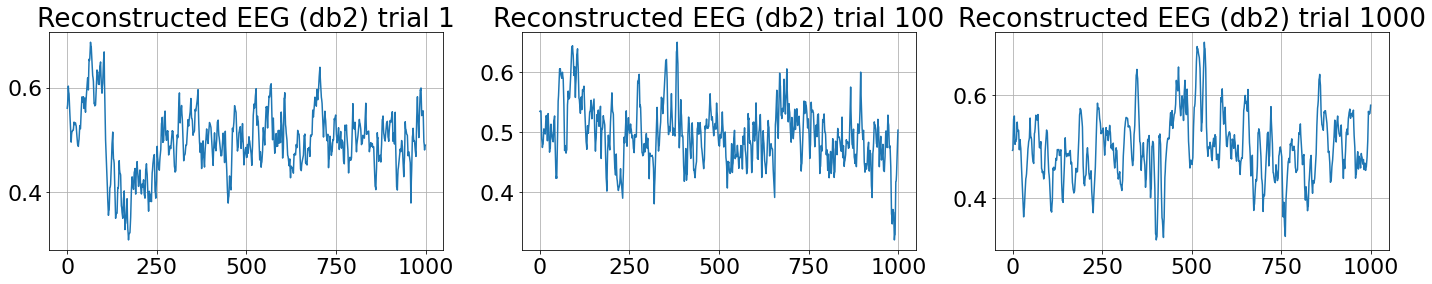

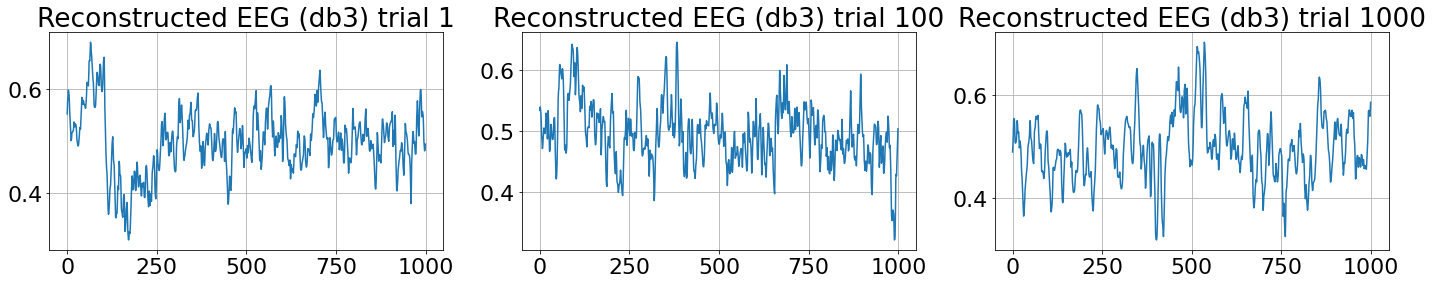

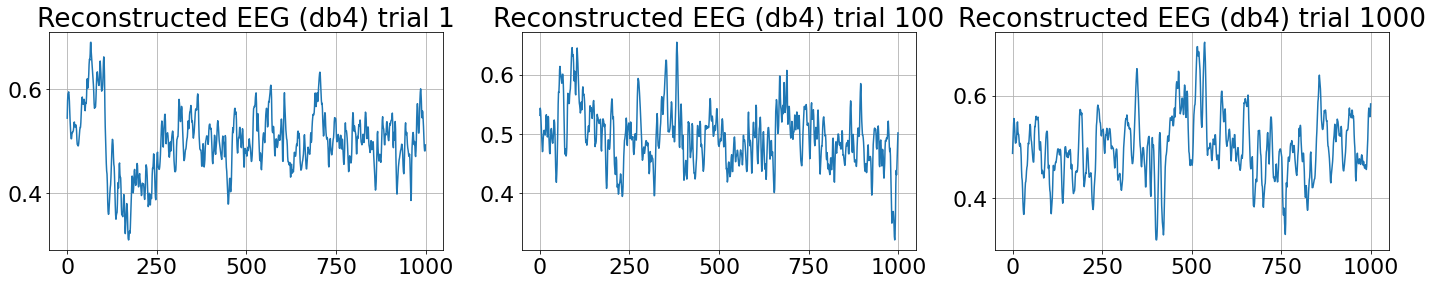

In [107]:
def func_plotEEG(X, trial_list, fig_name, path_figures, subplot_title):
    # plot EEG signal according to the trial list
    numOfSample = len(trial_list)
    time_step = X.shape[2]
    fig, axes = plt.subplots(1, numOfSample)
    fig.set_size_inches(8*numOfSample,4)
    for i in range(numOfSample):
        axes[i].plot(np.arange(time_step), X[trial_list[i], 0, :]) # only plot the first node
        axes[i].grid(True)
        axes[i].title.set_text(subplot_title + ' trial '+ str(trial_list[i]))
    fig.savefig(os.path.join(path_figures, fig_name), bbox_inches='tight')

def func_fitsvm(X, y):
    X = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    clf = svm.SVC()
    clf.fit(X, y)
    return clf

def func_dwt(X, db_level):
    (cA, cD) = pywt.dwt(X, db_level)
    recon_X_cA = pywt.idwt(cA, None, db_level)
    recon_X_cD = pywt.idwt(cD, None, db_level)
    return cA, cD, recon_X_cA, recon_X_cD

cA_db1, _, recon_db1_X_train_valid, _ = func_dwt(X_train_valid, 'db1')
cA_db2, _, recon_db2_X_train_valid, _ = func_dwt(X_train_valid, 'db2')
cA_db3, _, recon_db3_X_train_valid, _ = func_dwt(X_train_valid, 'db3')
cA_db4, _, recon_db4_X_train_valid, _ = func_dwt(X_train_valid, 'db4')

trial_list = [1,100,1000]
func_plotEEG(X_train_valid, trial_list, 'org_X_train_valid.pdf', path_figures, 'Original EEG')
func_plotEEG(recon_db1_X_train_valid, trial_list, 'recon_db1_X_train_valid.pdf', path_figures, 'Reconstructed EEG (db1)')
func_plotEEG(recon_db2_X_train_valid, trial_list, 'recon_db2_X_train_valid.pdf', path_figures, 'Reconstructed EEG (db2)')
func_plotEEG(recon_db3_X_train_valid, trial_list, 'recon_db3_X_train_valid.pdf', path_figures, 'Reconstructed EEG (db3)')
func_plotEEG(recon_db4_X_train_valid, trial_list, 'recon_db4_X_train_valid.pdf', path_figures, 'Reconstructed EEG (db4)')

svm_db1 = func_fitsvm(cA_db1, y_train_valid)
svm_db2 = func_fitsvm(cA_db2, y_train_valid)
svm_db3 = func_fitsvm(cA_db3, y_train_valid)
svm_db4 = func_fitsvm(cA_db4, y_train_valid)

In [108]:
test_cA_db1, _, recon_db1_X_test, _ = func_dwt(X_test, 'db1')
test_cA_db2, _, recon_db2_X_test, _ = func_dwt(X_test, 'db2')
test_cA_db3, _, recon_db3_X_test, _ = func_dwt(X_test, 'db3')
test_cA_db4, _, recon_db4_X_test, _ = func_dwt(X_test, 'db4')

def func_testReshape(X):
    return np.reshape(X, (X.shape[0],X.shape[1]*X.shape[2]))

pred_db1 = svm_db1.predict(func_testReshape(test_cA_db1))
pred_db2 = svm_db2.predict(func_testReshape(test_cA_db2))
pred_db3 = svm_db3.predict(func_testReshape(test_cA_db3))
pred_db4 = svm_db4.predict(func_testReshape(test_cA_db4))


In [110]:
print('wavelet db1 accuracy:', accuracy_score(pred_db1, y_test))
print('wavelet db2 accuracy:', accuracy_score(pred_db2, y_test))
print('wavelet db3 accuracy:', accuracy_score(pred_db3, y_test))
print('wavelet db4 accuracy:', accuracy_score(pred_db4, y_test))

wavelet db1 accuracy: 0.3927765237020316
wavelet db2 accuracy: 0.3927765237020316
wavelet db3 accuracy: 0.39503386004514673
wavelet db4 accuracy: 0.3837471783295711


Compute TSNE embedding

In [116]:
# compute the tsne-embedding and use SVM for feature selection
tsne_train_valid = TSNE(n_components=3).fit_transform(np.reshape(X_train_valid, (X_train_valid.shape[0], X_train_valid.shape[1]*X_train_valid.shape[2])))
tsne_test = TSNE(n_components=3).fit_transform(np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2])))

svm_tsne = svm.SVC()
svm_tsne.fit(tsne_train_valid, y_train_valid)
pred_tsne = svm_tsne.predict(tsne_test)

print('tsne accuracy', accuracy_score(pred_tsne, y_test))

/home/xiaoranzhang/anaconda3/envs/torch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/xiaoranzhang/anaconda3/envs/torch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/xiaoranzhang/anaconda3/envs/torch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/xiaoranzhang/anaconda3/envs/torch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tsne accuracy 0.2618510158013544


In [72]:
# implement the neural network embedding
def evaluate(model, validation_set, loss_fn):
    with torch.no_grad(): 
        numOfCorrectLabels = 0
        total_loss = 0
        for data, label in validation_set:
            model_input = torch.reshape(data, (data.shape[0], 1, data.shape[1], data.shape[2])) # expand one dimension for the channel for the EGG
            model_input = model_input.to('cuda')
            label = label.to('cuda')

            pred_onehot, x_embd = model(model_input)
            pred = torch.argmax(pred_onehot, dim=1)

            eval_loss = loss_fn(pred_onehot, label.to(torch.long))

            total_loss += eval_loss.item()
            numOfCorrectLabels += (pred == label).float().sum()

        accuracy = numOfCorrectLabels / len(validation_set.dataset)
        total_loss /= len(validation_set.dataset)
    return accuracy, total_loss

class ShallowCNN(nn.Module):
    """ Simple feed forward network with one hidden layer."""
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 40, (1, 25), padding='valid')
        self.conv2 = nn.Conv2d(1, 40, (880, 1), padding='valid')
        self.pool1 = nn.AvgPool2d(kernel_size=(1,75), stride=(1, 15))
        self.ln1 = nn.Linear(2440, 4)

    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape) # bs x 40 x 22 x 976
        x = torch.reshape(x, (x.shape[0], 1, 880, 976))
        x = relu(self.conv2(x))
        # print(x.shape) # bs x 40 x 1 x 976
        x = torch.reshape(x, (x.shape[0], 40, 976))
        x = relu(self.pool1(x)) 
        x_embd = torch.flatten(x, start_dim=1) # flatten the batched array
        # print(x_embd.shape) # bs x 2440
        pred = softmax(self.ln1(x_embd))
        # print(x.shape) # bs x 4

        return pred, x_embd

# create train and validation set for shallow CNN
n_split = 0.8
bs = 4
num_epoch = 1000
lr = 1e-4
numOfSample = X_train_valid.shape[0]


X_train = torch.Tensor(X_train_valid[:int(n_split*numOfSample)])
y_train = torch.Tensor(y_train_valid[:int(n_split*numOfSample)])
X_valid = torch.Tensor(X_train_valid[int(n_split*numOfSample):])
y_valid = torch.Tensor(y_train_valid[int(n_split*numOfSample):])

EEG_train_dataset = DataLoader(TensorDataset(X_train, y_train), batch_size=bs, shuffle=True)
EEG_valid_dataset = DataLoader(TensorDataset(X_valid, y_valid), batch_size=bs, shuffle=True)

print('Training input shape', X_train.shape)
print('Validation input shape', X_valid.shape)

model = ShallowCNN()
model.to('cuda')
CE_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# start training
base_valid_acc = 0
train_acc_list, train_loss_list, valid_acc_list, valid_loss_list = [], [], [], []
for epoch_idx in range(num_epoch):
    for data, label in EEG_train_dataset:
        optimizer.zero_grad()
        model_input = torch.reshape(data, (data.shape[0], 1, data.shape[1], data.shape[2])) # expand one dimension for the channel for the EGG
        model_input = model_input.to('cuda')
        label = label.to('cuda')

        pred_onehot, x_embd = model(model_input)
        pred = torch.argmax(pred_onehot, dim=1)

        loss = CE_loss(pred_onehot.to(torch.float32), label.to(torch.long)) # pred onhot, label just digit (long tensor!!!)
    
        # print(one_hot(label.to(torch.int64)).to(torch.float32).shape)
        loss.backward()

        optimizer.step()

    if epoch_idx % 10 == 0:
        train_acc, train_loss = evaluate(model, EEG_train_dataset, CE_loss)
        valid_acc, valid_loss = evaluate(model, EEG_valid_dataset, CE_loss)
        train_acc_list.append(train_acc), valid_acc_list.append(valid_acc)
        train_loss_list.append(train_loss), valid_loss_list.append(valid_loss)
        print(f" EPOCH {epoch_idx}. Progress: {epoch_idx/num_epoch*100}%. ")
        print(f" Train accuracy: {train_acc}. Valid accuracy: {valid_acc}")
        print(f" Train CE loss: {train_loss}. Valid CE loss: {valid_loss}")

        if valid_acc > base_valid_acc:
            base_valid_acc = valid_acc
            torch.save(model.state_dict(), os.path.join(path_model, 'model_shallowCNN_bs_{}_lr_{}_epoch_{}.pth'.format(str(bs), str(lr), str(num_epoch))))


Training input shape torch.Size([1692, 22, 1000])
Validation input shape torch.Size([423, 22, 1000])


/tmp/ipykernel_1222/3743213622.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = softmax(self.ln1(x_embd))


 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.25591015815734863. Valid accuracy: 0.2600472867488861
 Train CE loss: 0.3465652133274304. Valid CE loss: 0.34738125896904765
 EPOCH 10. Progress: 1.0%. 
 Train accuracy: 0.25591015815734863. Valid accuracy: 0.2600472867488861
 Train CE loss: 0.3465599419095556. Valid CE loss: 0.347365885479794
 EPOCH 20. Progress: 2.0%. 
 Train accuracy: 0.256501168012619. Valid accuracy: 0.2600472867488861
 Train CE loss: 0.34643832060462193. Valid CE loss: 0.347255830787316
 EPOCH 30. Progress: 3.0%. 
 Train accuracy: 0.3705673813819885. Valid accuracy: 0.3356974124908447
 Train CE loss: 0.33522355577624435. Valid CE loss: 0.3403340093351143
 EPOCH 40. Progress: 4.0%. 
 Train accuracy: 0.40070921182632446. Valid accuracy: 0.368794322013855
 Train CE loss: 0.32534531998859795. Valid CE loss: 0.3360229293787169
 EPOCH 50. Progress: 5.0%. 
 Train accuracy: 0.45035460591316223. Valid accuracy: 0.38770684599876404
 Train CE loss: 0.3191464067773616. Valid CE l

In [80]:
np.save(os.path.join(path_model, 'train_acc_list.npy'), np.asarray(torch.Tensor(train_acc_list).cpu()))
np.save(os.path.join(path_model, 'train_loss_list.npy'), np.asarray(torch.Tensor(train_loss_list).cpu()))
np.save(os.path.join(path_model, 'valid_acc_list.npy'), np.asarray(torch.Tensor(valid_acc_list).cpu()))
np.save(os.path.join(path_model, 'valid_loss_list.npy'), np.asarray(torch.Tensor(valid_loss_list).cpu()))

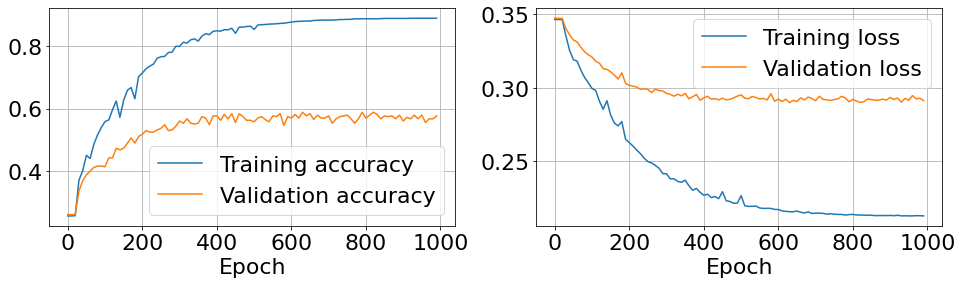

In [93]:
def func_plotCNNStats(path_figures, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(8*2,4)
    epoch_grid = np.arange(0, 1000, 10)
    axes[0].plot(epoch_grid, train_acc_list, label='Training accuracy')
    axes[0].plot(epoch_grid, valid_acc_list, label='Validation accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].grid(True)
    axes[0].legend()
    # axes[0].title.set_text('Train and validation accuracy')

    axes[1].plot(epoch_grid, train_loss_list, label='Training loss')
    axes[1].plot(epoch_grid, valid_loss_list, label='Validation loss')
    axes[1].set_xlabel('Epoch')
    axes[1].grid(True)
    axes[1].legend()
    # axes[1].title.set_text('Train and validation cross entropy loss')

    fig.savefig(os.path.join(path_figures, 'training_stats.pdf'), bbox_inches='tight')

train_acc_list, train_loss_list = np.load(os.path.join(path_model, 'train_acc_list.npy')), np.load(os.path.join(path_model, 'train_loss_list.npy'))
valid_acc_list, valid_loss_list = np.load(os.path.join(path_model, 'valid_acc_list.npy')), np.load(os.path.join(path_model, 'valid_loss_list.npy'))

func_plotCNNStats(path_figures, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list)


In [82]:
# start testing
model_name = 'model_shallowCNN_bs_{}_lr_{}_epoch_{}.pth'.format(str(bs), str(lr), str(num_epoch))
model_path = os.path.join(path_model, model_name)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

EEG_test_dataset = DataLoader(TensorDataset(X_test, y_test))

model = ShallowCNN()
model.load_state_dict(torch.load(model_path))
model = model.cuda()
model.eval()

test_numOfCorrectLabels = 0
test_embed_list = []
for test_data, test_label in EEG_test_dataset:
    # test_data.to('cuda')

    test_input = torch.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1], test_data.shape[2])) # expand one dimension for the channel for the EGG
    test_input = test_input.to('cuda')

    test_pred_onehot, test_x_embd = model(test_input)
    test_embed_list.append(test_x_embd.detach().cpu().numpy())
    
    test_pred = torch.argmax(test_pred_onehot, dim=1).cpu()

    test_numOfCorrectLabels += (test_pred == test_label).float().sum()
        
test_accuracy = test_numOfCorrectLabels / len(EEG_test_dataset.dataset)

print('Test accuracy of ShallowCNN is', test_accuracy.numpy())

/tmp/ipykernel_1222/3743213622.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = softmax(self.ln1(x_embd))


Test accuracy of ShallowCNN is 0.5756208


In [137]:
test_shallowCNN_embed = np.vstack(test_embed_list)
print(test_shallowCNN_embed.shape)

(443, 2440)


/home/xiaoranzhang/anaconda3/envs/torch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/xiaoranzhang/anaconda3/envs/torch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/xiaoranzhang/anaconda3/envs/torch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/xiaoranzhang/anaconda3/envs/torch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/xiaoranzhang/anaconda3/envs/torch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in T

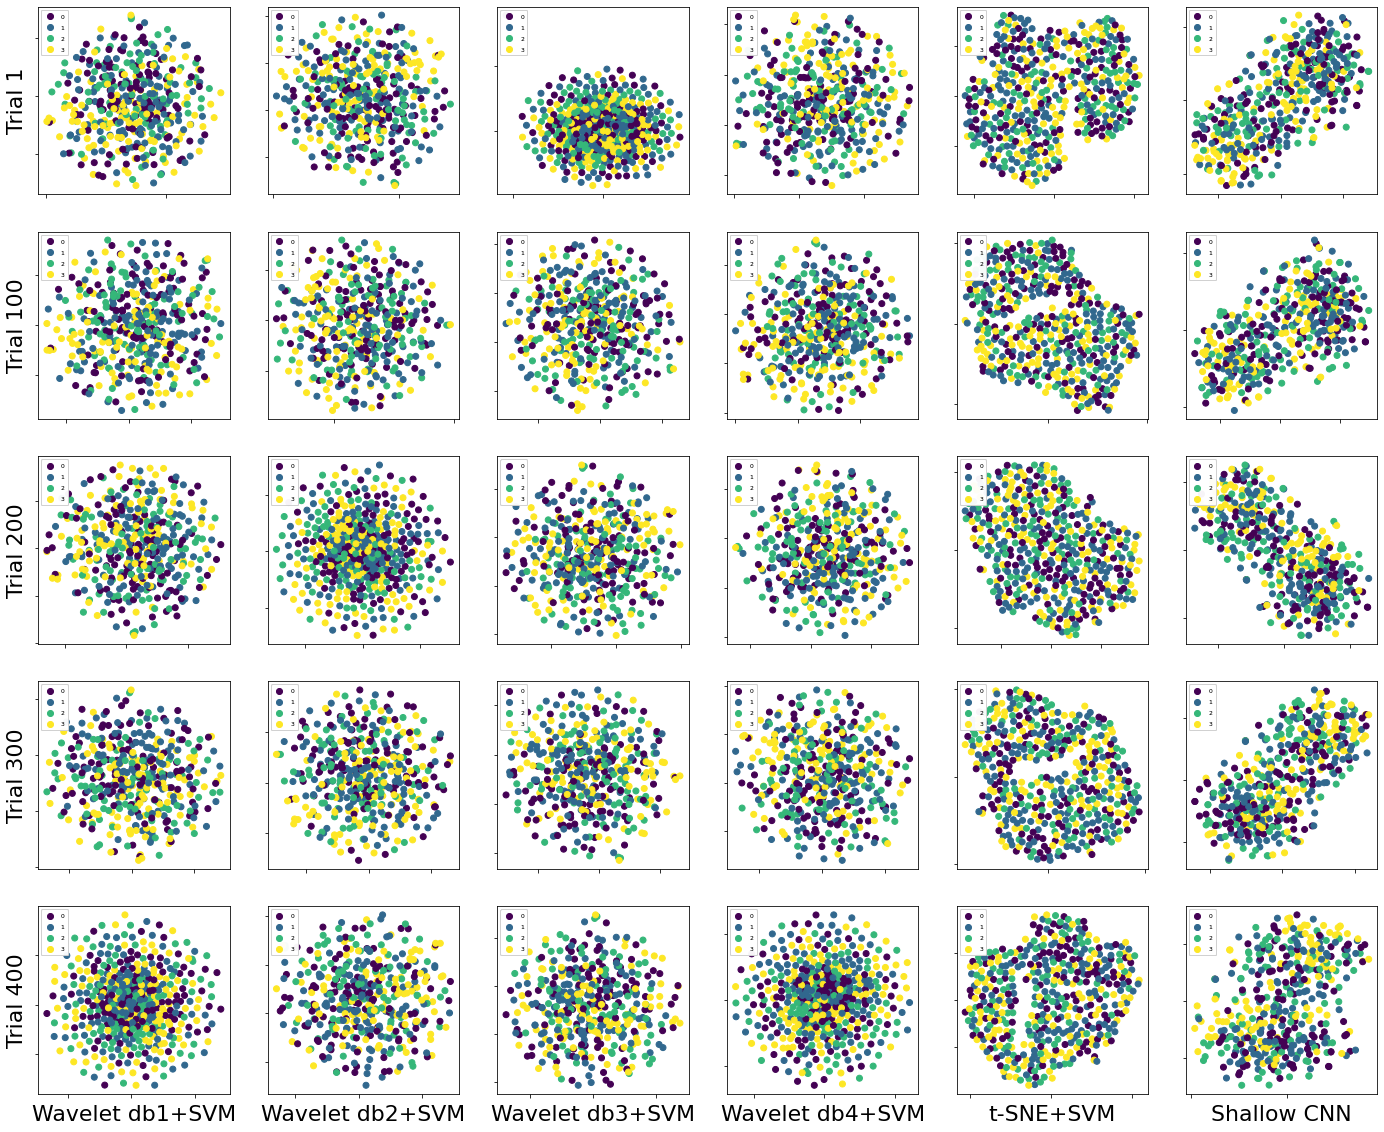

In [142]:
import matplotlib.pyplot as plt

trial_index_list = [1, 100, 200, 300, 400]

fig, axes = plt.subplots(5, 6)
fig.set_size_inches((24, 20))

perplexity = 30


for fig_idx, idx in enumerate(trial_index_list):
    # wavelet db1 tsne
    db1_tsne = TSNE(perplexity=perplexity).fit_transform(func_testReshape(test_cA_db1))
    scatter = axes[fig_idx][0].scatter(db1_tsne[:,0], db1_tsne[:,1], c=y_test)
    legend = axes[fig_idx][0].legend(*scatter.legend_elements(), prop={'size':6}, loc='upper left')
    axes[fig_idx][0].add_artist(legend)
    axes[fig_idx][0].set_xticklabels([])
    axes[fig_idx][0].set_yticklabels([])
    # axes[fig_idx][0].axis('off')

    db2_tsne = TSNE(perplexity=perplexity).fit_transform(func_testReshape(test_cA_db2))
    scatter = axes[fig_idx][1].scatter(db2_tsne[:,0], db2_tsne[:,1], c=y_test)
    legend = axes[fig_idx][1].legend(*scatter.legend_elements(), prop={'size':6}, loc='upper left')
    axes[fig_idx][1].add_artist(legend)
    axes[fig_idx][1].set_xticklabels([])
    axes[fig_idx][1].set_yticklabels([])
    # axes[fig_idx][1].axis('off')

    db3_tsne = TSNE(perplexity=perplexity).fit_transform(func_testReshape(test_cA_db3))
    scatter = axes[fig_idx][2].scatter(db3_tsne[:,0], db3_tsne[:,1], c=y_test)
    legend = axes[fig_idx][2].legend(*scatter.legend_elements(), prop={'size':6}, loc='upper left')
    axes[fig_idx][2].add_artist(legend)
    axes[fig_idx][2].set_xticklabels([])
    axes[fig_idx][2].set_yticklabels([])
    # axes[fig_idx][2].axis('off')

    db4_tsne = TSNE(perplexity=perplexity).fit_transform(func_testReshape(test_cA_db4))
    scatter = axes[fig_idx][3].scatter(db4_tsne[:,0], db4_tsne[:,1], c=y_test)
    legend = axes[fig_idx][3].legend(*scatter.legend_elements(), prop={'size':6}, loc='upper left')
    axes[fig_idx][3].add_artist(legend)
    axes[fig_idx][3].set_xticklabels([])
    axes[fig_idx][3].set_yticklabels([])
    # axes[fig_idx][3].axis('off')

    tsne_2d = TSNE(perplexity=perplexity).fit_transform(tsne_test)
    scatter = axes[fig_idx][4].scatter(tsne_2d[:,0], tsne_2d[:,1], c=y_test)
    legend = axes[fig_idx][4].legend(*scatter.legend_elements(), prop={'size':6}, loc='upper left')
    axes[fig_idx][4].add_artist(legend)
    axes[fig_idx][4].set_xticklabels([])
    axes[fig_idx][4].set_yticklabels([])
    # axes[fig_idx][4].axis('off')

    CNN_tsne = TSNE(perplexity=perplexity).fit_transform(test_shallowCNN_embed)
    scatter = axes[fig_idx][5].scatter(CNN_tsne[:,0], CNN_tsne[:,1], c=y_test)
    legend = axes[fig_idx][5].legend(*scatter.legend_elements(), prop={'size':6}, loc='upper left')
    axes[fig_idx][5].add_artist(legend)
    axes[fig_idx][5].set_xticklabels([])
    axes[fig_idx][5].set_yticklabels([])
    # axes[fig_idx][5].axis('off')

    axes[fig_idx][0].set_ylabel('Trial {}'.format(trial_index_list[fig_idx]))
    # break

axes[fig_idx][0].set_xlabel('Wavelet db1+SVM')
axes[fig_idx][1].set_xlabel('Wavelet db2+SVM')
axes[fig_idx][2].set_xlabel('Wavelet db3+SVM')
axes[fig_idx][3].set_xlabel('Wavelet db4+SVM')
axes[fig_idx][4].set_xlabel('t-SNE+SVM')
axes[fig_idx][5].set_xlabel('Shallow CNN')

fig.savefig(os.path.join(path_figures, 'embedding_cmp.pdf'), bbox_inches='tight')